In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import os
from glob import glob

import numpy as np
import pandas as pd

import skimage.io as io
io.use_plugin('matplotlib')

import moviepy.editor as mpy

import menpo
import menpo.io as mio
from menpo.io import export_image, export_landmark_file
from menpowidgets import visualize_images

from pathlib import Path

from tqdm import tqdm

In [3]:
from menpo.landmark import face_ibug_68_to_face_ibug_68_trimesh, face_ibug_68_to_face_ibug_68, labeller

# method to load a database
def load_database(path_to_images, crop_percentage, max_images=None):
    images = []
    # load landmarked images
    for i in mio.import_images(path_to_images, max_images=max_images, verbose=True):
        # crop image
        i = i.crop_to_landmarks_proportion(crop_percentage)
        
        # convert it to grayscale if needed
        #if i.n_channels == 3:
        #    i = i.as_greyscale(mode='luminosity')
        
        # convert to float32
        i.pixels = i.pixels.astype(np.float32)
        
        # imesh
        labeller(i, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)
        
        # append it to the list
        images.append(i)
    return images

# for vids
def vid_landmark_resolver(path, frame_number, paths_callable=mio.landmark_file_paths):
    r"""
    Default video landmark resolver. Returns all landmarks found to have
    the same stem as the asset.
    """
    # pattern finding all landmarks with the same stem
    pattern = path.with_name('annot/%06i.*' % (frame_number + 1))
    # find all the assets we can with this name. Key is extension
    return {p.suffix[1:].upper(): p for p in paths_callable(pattern)}

# Load Images

## Photos

In [4]:
training_images = []

path_to_lfpw = Path('/projects/face_databases/annots/lfpw/trainset')
tmp = load_database(path_to_lfpw, 0.1)
training_images = training_images + tmp

path_to_ibug = Path('/projects/face_databases/annots/ibug')
tmp = load_database(path_to_ibug, 0.1)
training_images = training_images + tmp

path_to_300w = Path('/projects/face_databases/annots/300w')
tmp = load_database(path_to_300w, 0.1)
training_images = training_images + tmp

path_to_afw = Path('/projects/face_databases/annots/afw')
tmp = load_database(path_to_afw, 0.1)
training_images = training_images + tmp

path_to_helen = Path('/projects/face_databases/annots/helen/trainset')
tmp = load_database(path_to_helen, 0.1)
training_images = training_images + tmp

path_to_xm2vts = Path('/projects/face_databases/annots/xm2vts')
tmp = load_database(path_to_xm2vts, 0.1)
training_images = training_images + tmp

Found 811 assets, index the returned LazyList to import.
Found 135 assets, index the returned LazyList to import.
Found 600 assets, index the returned LazyList to import.
Found 337 assets, index the returned LazyList to import.
Found 2000 assets, index the returned LazyList to import.
Found 2360 assets, index the returned LazyList to import.


In [5]:
len(training_images)

6243

## Videos: 300VW

Gets a frame every 5s.

In [6]:
fps = 25
n = len(os.listdir('/projects/face_databases/300VW'))
print(n)
for j,video in tqdm(enumerate(mio.import_videos('/projects/face_databases/300VW/*/vid.avi', landmark_resolver=vid_landmark_resolver)), total=50):
    for ii in range(0,len(video),fps*5):
        i = video[ii]
        
        # crop image
        i = i.crop_to_landmarks_proportion(0.1)
        
        # convert it to grayscale if needed
        #if i.n_channels == 3:
        #    i = i.as_greyscale(mode='luminosity')
            
        # convert to float32
        i.pixels = i.pixels.astype(np.float32)
        
        # imesh
        labeller(i, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)
        
        training_images.append(i)

  0%|          | 0/50 [00:00<?, ?it/s]

50


100%|██████████| 50/50 [06:17<00:00,  5.39s/it]


In [7]:
len(training_images)

7029

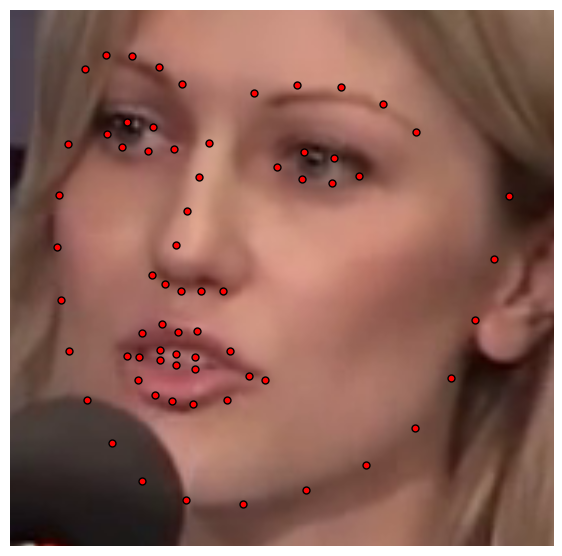

In [10]:
visualize_images(training_images)

# Save Images

For the neural network.

In [ ]:
os.mkdir('/data1/famface01/data/stimuli/pics/landmark_facedb/orig')

In [12]:
outdir = '/data1/famface01/data/stimuli/pics/landmark_facedb/orig'
#mkdir...
for i,img in tqdm(enumerate(training_images), total=len(training_images)):
    if i < 6243:
        ofile1 = "%s/img_%05i.jpg" % (outdir, i)
        ofile2 = "%s/img_%05i.pts" % (outdir, i)
    else:
        ofile1 = "%s/vid_%05i.jpg" % (outdir, i)
        ofile2 = "%s/vid_%05i.pts" % (outdir, i)        
    export_image(img, ofile1, overwrite=True)
    export_landmark_file(img.landmarks['PTS'], ofile2, overwrite=True)

100%|██████████| 7029/7029 [02:50<00:00, 41.20it/s]


# Run Neural Net

In [20]:
!cd ~/Downloads/openface
os.chdir("/home/zshehzad/Downloads/openface")

In [25]:
os.mkdir("/data1/famface01/data/stimuli/pics/landmark_facedb/nnet")

In [21]:
# See output on command-line
base="/data1/famface01/data/stimuli/pics/landmark_facedb"
cmd = "./util/use-aligned.py %s/orig align outerEyesAndNose %s/align --size 96" % (base,base)
os.system(cmd)

0

In [26]:
cmd = "./batch-represent/main.lua -data %s/align -outDir %s/nnet/" % (base,base)
os.system(cmd)

0

In [29]:
# copy over those features to the folder where I've get everything else
!ls /data1/famface01/data/stimuli/pics/landmark_facedb/nnet

labels.csv  reps.csv


In [30]:
!cp /data1/famface01/data/stimuli/pics/landmark_facedb/nnet/labels.csv /data1/famface01/analysis/misc/openface/landmark_facedb_labels.csv
!cp /data1/famface01/data/stimuli/pics/landmark_facedb/nnet/reps.csv /data1/famface01/analysis/misc/openface/landmark_facedb_reps.csv